# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate

## The Euro problem


We can make a uniform prior and update it with 140 heads and 110 tails:

In [3]:
hypos = np.arange(0, 101)
uniform = Pmf(1, hypos, name='uniform')

In [4]:
likelihood_dict = dict(
    H = hypos/100,
    T = 1 - hypos/100
)

In [5]:
dataset = 'H' * 140 + 'T' * 110

In [6]:
pmf = uniform.copy()

for data in dataset:
    pmf *= likelihood_dict[data]

pmf.normalize()

2.6349205016724192e-74

And here's what the posterior looks like.

In [7]:
def decorate_euro():
    decorate(xlabel='Probability of heads',
             ylabel='PMF')

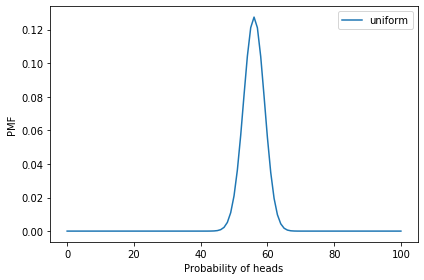

In [8]:
pmf.plot()
decorate_euro()

We can summarize the posterior several ways, including the mean:

In [9]:
pmf.mean()

55.952380952380956

Median:

In [10]:
pmf.median()

array(56.)

The peak of the posterior, known as the Maximum Aposteori Probability (MAP)

In [11]:
pmf.mode()

56

And a 90% credible interval

In [12]:
pmf.credible_interval(0.9)

array([51., 61.])

We can look up a particular value in the posterior PMF, but the result doesn't mean much, because we could have divided the range (0-100) into as many pieces as we like, and the result would be different.

In [13]:
pmf[50]

0.02097652612954467

## Different priors

Let's see how that looks with different priors.

In [14]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

And another that makes a triangular prior.

In [15]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()

2500

Here's what they look like:

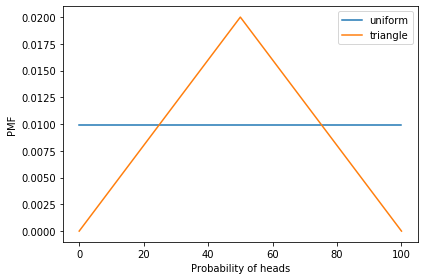

In [16]:
uniform.plot()
triangle.plot()
decorate_euro()

If we update them both with the same data:

In [17]:
def update_euro(pmf, dataset):
    """Updates the Suite with the given number of heads and tails.

    pmf:
    data: tuple of heads and tails
    """
    for data in dataset:
        pmf *= likelihood_dict[data]

    pmf.normalize()

In [18]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

The results are almost identical; the remaining difference is unlikely to matter in practice.

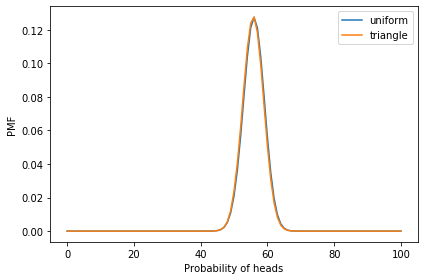

In [19]:
uniform.plot()
triangle.plot()
decorate_euro()

## The binomial likelihood function

We can make the Euro class more efficient by computing the likelihood of the entire dataset at once, rather than one coin toss at a time.

If the probability of heads is p, we can compute the probability of k=140 heads in n=250 tosses using the binomial PMF.

In [20]:
from scipy.stats import binom

def update_binomial(pmf, data):
    heads, tails = data

    k = heads
    n = heads + tails
    p = pmf.qs / 100
    
    likelihood = binom.pmf(k, n, p)
    print(likelihood.sum())
    pmf *= likelihood
    pmf.normalize()

I left out the binomial coefficient ${n}\choose{k}$ because it does not depend on `p`, so it's the same for all hypotheses.  

In [21]:
uniform2 = Pmf(1, hypos, name='uniform2')
data = 140, 110
update_binomial(uniform2, data)

0.398406374501959


Here's what the posterior looks like.

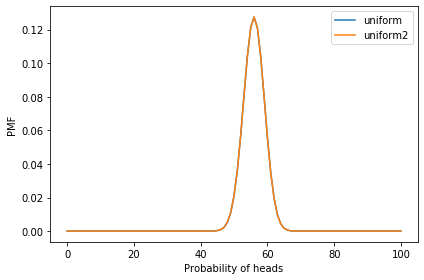

In [22]:
uniform.plot()
uniform2.plot()
decorate_euro()

## The Beta distribution

The Beta distribution is a conjugate prior for the binomial likelihood function, which means that if you start with a Beta distribution and update with a binomial likelihood, the posterior is also Beta.

Also, given the parameters of the prior and the data, we can compute the parameters of the posterior directly.  The following class represents a Beta distribution and provides a constant-time Update method.

In [23]:
import scipy.stats

class Beta:
    """Represents a Beta distribution.

    See http://en.wikipedia.org/wiki/Beta_distribution
    """
    def __init__(self, alpha=1, beta=1):
        """Initializes a Beta distribution."""
        self.alpha = alpha
        self.beta = beta

    def update(self, data):
        """Updates a Beta distribution.

        data: pair of int (heads, tails)
        """
        heads, tails = data
        self.alpha += heads
        self.beta += tails

    def mean(self):
        """Computes the mean of this distribution."""
        return self.alpha / (self.alpha + self.beta)

    def mode(self):
        """Computes the value with maximum a posteori probability."""
        a = self.alpha - 1
        b = self.beta - 1
        return a / (a + b)

    def random(self):
        """Generates a random variate from this distribution."""
        return random.betavariate(self.alpha, self.beta)

    def sample(self, n):
        """Generates a random sample from this distribution.

        n: int sample size
        """
        size = n,
        return np.random.beta(self.alpha, self.beta, size)

    def eval_pdf(self, qs):
        """Evaluates the PDF at qs."""
        return scipy.stats.beta.pdf(qs, self.alpha, self.beta)
    
    def eval_cdf(self, qs):
        """Evaluates the CDF at qs."""
        return scipy.stats.beta.cdf(qs, self.alpha, self.beta)
    
    def quantile(self, ps):
        """Returns the given percentiles from this distribution.

        ps: scalar, array, or list of [0-1]
        """
        return scipy.stats.beta.ppf(qs, self.alpha, self.beta)

    def make_pmf(self, num=101):
        """Returns a Pmf of this distribution.

        Note: Normally, we just evaluate the PDF at a sequence
        of points and treat the probability density as a probability
        mass.

        But if alpha or beta is less than one, we have to be
        more careful because the PDF goes to infinity at x=0
        and x=1.  In that case we evaluate the CDF and compute
        differences.

        The result is a little funny, because the values at 0 and 1
        are not symmetric.  Nevertheless, it is a reasonable discrete
        model of the continuous distribution, and behaves well as
        the number of values increases.
        """
        if self.alpha < 1 or self.beta < 1:
            cdf = self.make_cdf()
            pmf = cdf.make_pmf()
            return pmf

        qs = np.linspace(0, 1, num)
        ps = self.eval_pdf(qs)
        return Pmf(ps, qs)

    def make_cdf(self, num=101):
        """Returns the CDF of this distribution."""
        qs = np.linspace(0, 1, num)
        ps = self.eval_cdf(qs)
        return Cdf(ps, qs)

Here's how we use it.

In [24]:
beta = Beta(1, 1)
beta.update((140, 110))
beta.mean()

0.5595238095238095

And here's the posterior.

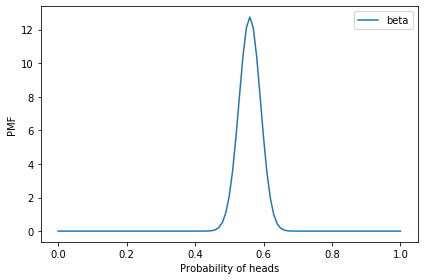

In [25]:
beta.make_pmf().plot(label='beta')
decorate_euro()

Amazing, no?

**Exercise:** One way to construct priors is to make a Beta distribution and adjust the parameters until it has the shape you want.  Then when you do an update, the data get added to the parameters of the prior.  Since the parameters of the prior play the same mathematical role as the data, they are sometimes called "precounts".

Suppose you believe that most coins are fair or unlikely to deviate from 50% by more than a few percentage points.  Construct a prior that captures this belief and update it with the Euro data.  How much effect does it have on the posterior, compared to the uniform prior?

Hint: A Beta distribution with parameters `(1, 1)` is uniform from 0 to 1.

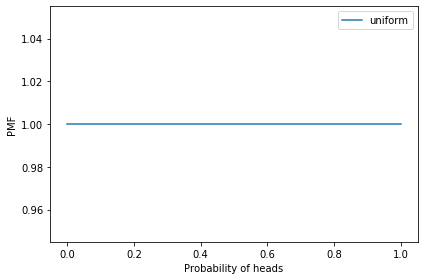

In [26]:
# Solution

# Here's the uniform prior
    
uniform = Beta(1, 1)
uniform.make_pmf().plot(label='uniform')
decorate_euro()

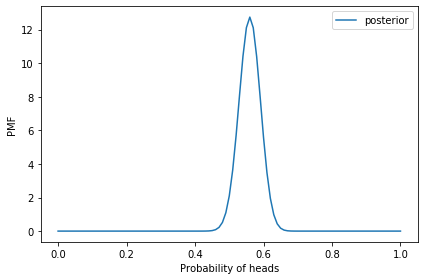

In [27]:
# Solution

# And here's what it looks like after the update
    
uniform.update(data)
uniform.make_pmf().plot(label='posterior')
decorate_euro()

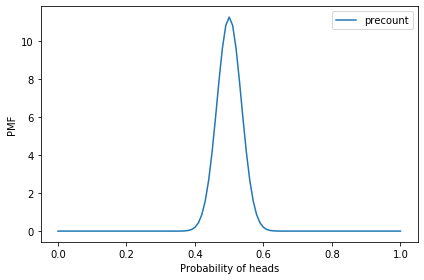

In [28]:
# Solution

# Here's a beta prior with precounts chosen to represent
# background knowledge about coins.
    
beta = Beta(100, 100)
beta.make_pmf().plot(label='precount')
decorate_euro()

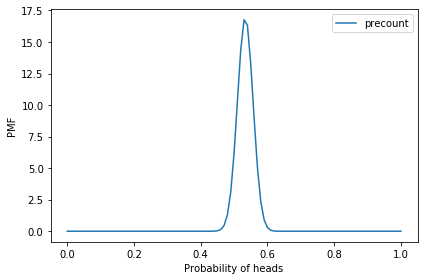

In [29]:
# Solution

# And here's what it looks like after the update
    
beta.update(data)
beta.make_pmf().plot(label='precount')
decorate_euro()

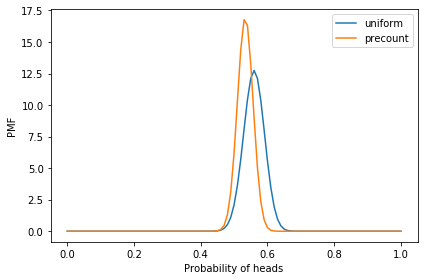

In [30]:
# Solution

# Comparing the two, we see that the informative
# prior influences the location and spread of the
# posterior.
    
uniform.make_pmf().plot(label='uniform')
beta.make_pmf().plot(label='precount')
decorate_euro()

In [31]:
beta.mean()

0.5333333333333333